In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,Input, Dense, Lambda, Layer, Add, Multiply

from tensorflow.keras import backend as K
#
#from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 20
epsilon_std = 1.0


In [3]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [4]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.


In [6]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=80,
        batch_size=batch_size,
        validation_data=(x_test, y_test))

encoder = Model(x, z_mu)


Train on 60000 samples, validate on 10000 samples
Epoch 1/80


2023-03-03 10:53:45.750902: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3402225000 Hz
2023-03-03 10:53:45.751408: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5630d8c39a50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-03 10:53:45.751425: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


60000/60000 [==============================] - 4s 65us/sample - loss: 191.0509 - val_loss: 27901.6090
Epoch 2/80
60000/60000 [==============================] - 4s 60us/sample - loss: 170.4644 - val_loss: 31319.5270
Epoch 3/80
60000/60000 [==============================] - 4s 60us/sample - loss: 166.9959 - val_loss: 35104.2498
Epoch 4/80
60000/60000 [==============================] - 4s 60us/sample - loss: 164.8214 - val_loss: 38599.3205
Epoch 5/80
60000/60000 [==============================] - 4s 60us/sample - loss: 163.3041 - val_loss: 41806.5346
Epoch 6/80
60000/60000 [==============================] - 4s 60us/sample - loss: 162.0699 - val_loss: 44089.3800
Epoch 7/80
60000/60000 [==============================] - 4s 60us/sample - loss: 161.0326 - val_loss: 47890.7691
Epoch 8/80
60000/60000 [==============================] - 4s 60us/sample - loss: 160.0419 - val_loss: 49242.2690
Epoch 9/80
60000/60000 [==============================] - 4s 60us/sample - loss: 159.1504 - val_loss: 52111

60000/60000 [==============================] - 5s 82us/sample - loss: 148.1408 - val_loss: 92128.3838
Epoch 74/80
60000/60000 [==============================] - 4s 61us/sample - loss: 148.0897 - val_loss: 91616.1122
Epoch 75/80
60000/60000 [==============================] - 4s 62us/sample - loss: 148.0734 - val_loss: 89831.3462
Epoch 76/80
60000/60000 [==============================] - 4s 61us/sample - loss: 147.9784 - val_loss: 91944.4551
Epoch 77/80
60000/60000 [==============================] - 4s 61us/sample - loss: 147.9173 - val_loss: 90605.3178
Epoch 78/80
60000/60000 [==============================] - 4s 61us/sample - loss: 147.8495 - val_loss: 93219.8789
Epoch 79/80
60000/60000 [==============================] - 4s 60us/sample - loss: 147.8526 - val_loss: 91561.0067
Epoch 80/80
60000/60000 [==============================] - 4s 61us/sample - loss: 147.7902 - val_loss: 92613.1008


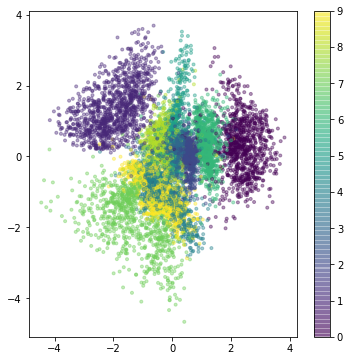

In [7]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()


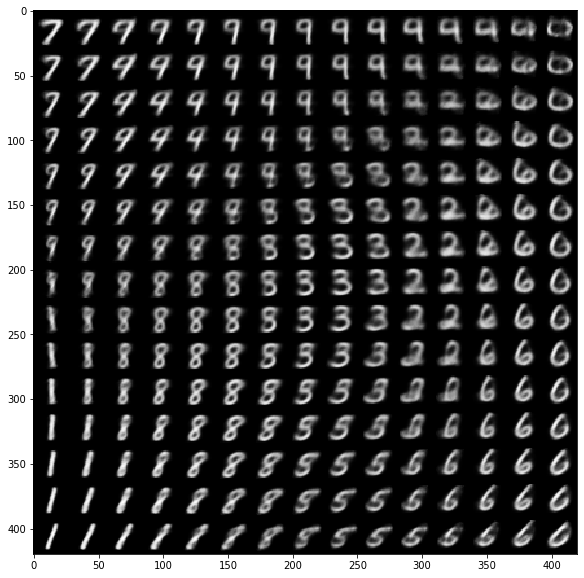

In [8]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')


In [21]:
val=[-2,-0]

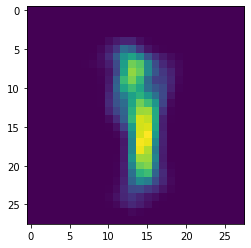

In [22]:
plt.imshow(decoder.predict(np.array(val).reshape(1,2)).reshape(digit_size, digit_size))